In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM
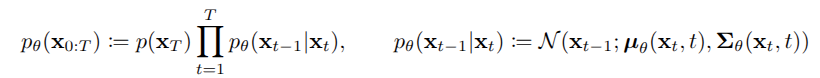
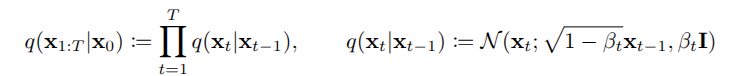
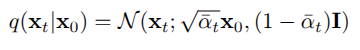
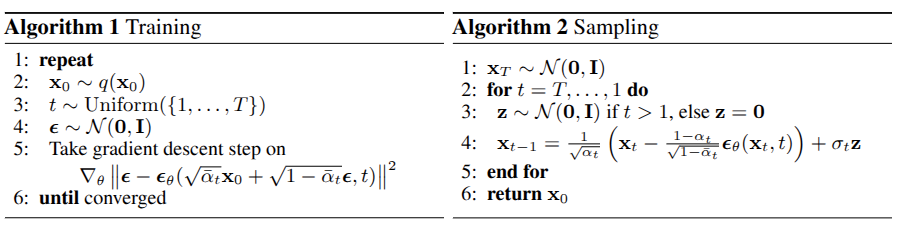

# TODO
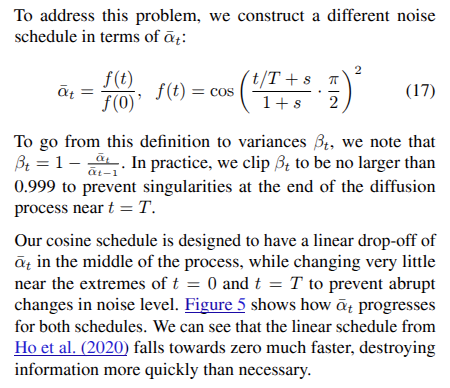

In [4]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class BasicDiffusion:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=0.0001,
        beta_end=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alpha = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)

        # Compute alpha_cumprod_prev and posterior_variance
        self.alpha_cumprod_prev = torch.cat(
            [torch.ones(1, device=device), self.alpha_cumprod[:-1]]
        )
        self.posterior_variance = (
            (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        ) * self.betas
        self.device = device
        self.model = model

    # q(xt|x0)
    def q(self, x_0, t):
        alpha_cumprod_t = gather(self.alpha_cumprod, t)
        mean = torch.sqrt(alpha_cumprod_t) * x_0
        var = 1.0 - alpha_cumprod_t
        return mean, var

    def q_sample(self, x_0, t, eps=None):
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps

    # p(x_t-1|x_t)
    def p_sample(self, x_t, t):
        x0_pred = self.model(x_t, t)

        alpha_bar_t = gather(self.alpha_cumprod, t)
        alpha_bar_prev_t = gather(self.alpha_cumprod_prev, t)
        alpha_t = gather(self.alpha, t)
        beta_t = gather(self.betas, t)

        mu_coef_x0 = (alpha_bar_prev_t.sqrt() * beta_t) / (1 - alpha_bar_t)
        mu_coef_xt = ((1 - alpha_bar_prev_t) * (1 - beta_t).sqrt()) / (1 - alpha_bar_t)
        # mu_coef_xt = (alpha_t.sqrt() * (1 - alpha_bar_prev_t)) / (1 - alpha_bar_t)

        mean = mu_coef_x0 * x0_pred + mu_coef_xt * x_t

        var = gather(self.posterior_variance, t)
        noise = torch.randn_like(x_t)
        mask = (t > 0).float()[:, None, None, None]
        x_t_prev = mean + torch.sqrt(var) * noise * mask

        return x_t_prev

    def loss(self, x0, noise=None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device).long()
        if noise is None:
            noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise)
        x0_pred = self.model(x_t, t)
        return F.mse_loss(x0_pred, x0)

    def forward(self, x0, noise=None):
        return self.loss(x0, noise)

    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition

        return torch.clamp(x_t, -1.0, 1.0)

# UNet (But I've used simple U-net here to compare CDPM with DDPM)
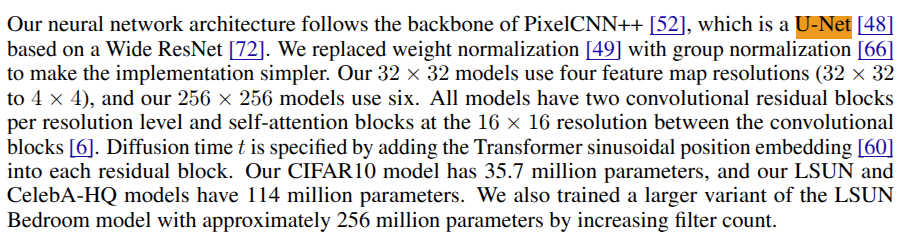
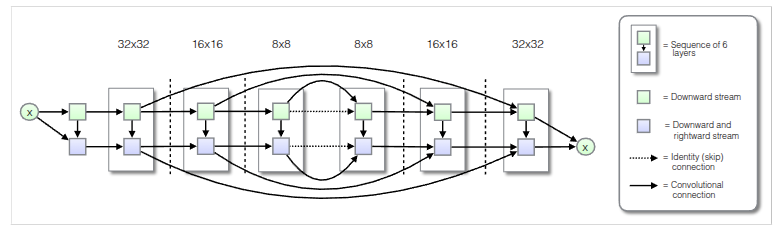

In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.proj = nn.Sequential(nn.Linear(1, dim), nn.SiLU(), nn.Linear(dim, dim))

    def forward(self, t):
        # t: [B,] -> [B, dim]
        return self.proj(t.unsqueeze(-1).float())


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm = nn.BatchNorm2d(out_ch)

    def forward(self, x, t_emb):
        h = self.conv1(x)
        t_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t_emb
        h = self.norm(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h


class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_emb = TimeEmbedding(32)

        # Downsample
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)

        # Middle
        self.mid = Block(128, 128, 32)

        # Upsample
        self.up1 = Block(128 + 64, 64, 32)  # + skip connection
        self.up2 = Block(64 + 32, 32, 32)  # + skip connection
        self.up3 = Block(32, 1, 32)  # Final output

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x, t):
        t_emb = self.time_emb(t)

        # Downsample
        x1 = self.down1(x, t_emb)  # [B, 32, 28, 28]
        x2 = self.pool(x1)  # [B, 32, 14, 14]
        x3 = self.down2(x2, t_emb)  # [B, 64, 14, 14]
        x4 = self.pool(x3)  # [B, 64, 7, 7]
        x5 = self.down3(x4, t_emb)  # [B, 128, 7, 7]

        # Middle
        x6 = self.mid(x5, t_emb)  # [B, 128, 7, 7]

        # Upsample
        x7 = self.upsample(x6)  # [B, 128, 14, 14]
        x7 = torch.cat([x7, x3], dim=1)  # [B, 128+64=192, 14, 14]
        x8 = self.up1(x7, t_emb)  # [B, 64, 14, 14]

        x9 = self.upsample(x8)  # [B, 64, 28, 28]
        x9 = torch.cat([x9, x1], dim=1)  # [B, 64+32=96, 28, 28]
        x10 = self.up2(x9, t_emb)  # [B, 32, 28, 28]

        x11 = self.up3(x10, t_emb)  # [B, 1, 28, 28]
        return x11

In [6]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)

        attn = torch.bmm(q, k) * (C**-0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Downsampling
        self.down1 = nn.ModuleList(
            [
                ResidualBlock(in_channels, base_channels, time_dim, groups=1),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )
        self.down2 = nn.ModuleList(
            [
                ResidualBlock(base_channels, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels * 2, time_dim),
            ]
        )

        # Middle
        self.mid = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels * 4, time_dim),
                SelfAttentionBlock(base_channels * 4),
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
            ]
        )

        # Upsampling
        self.up2 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels, time_dim),
            ]
        )
        self.up1 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels, time_dim),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )

        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []

        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14

        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7

        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)

        return self.final_conv(x)


# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)

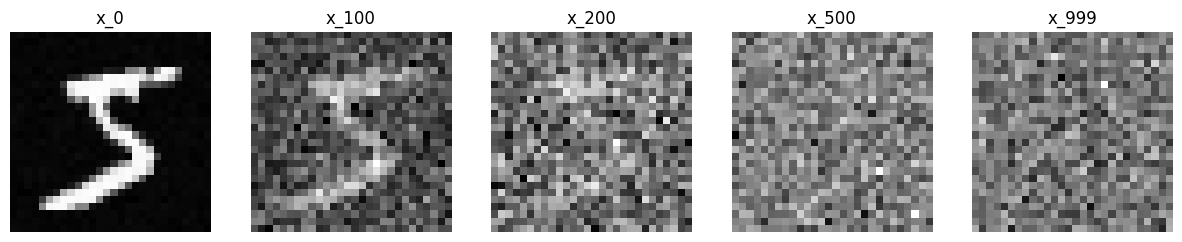

In [7]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("samples", exist_ok=True)

config = {
    "batch_size": 1280,
    "epochs": 200,
    "lr": 1e-4,
    "n_steps": 1000,
    "weight_decay": 1e-5,
    "max_grad_norm": 1.0,
    "save_interval": 50,
}

# Data augmentation
transform = transforms.Compose(
    [
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Initialization
model = SimpleUNet().to(device)
diffusion = BasicDiffusion(model, device, n_steps=config["n_steps"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
train_dataset = torchvision.datasets.MNIST(
    root="~/ainotebook/data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
sampled_image = dataloader.dataset.data[:1].unsqueeze(1).float() / 255.0

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    sampled_image = diffusion.q_sample(
        sampled_image.unsqueeze(0).to(device), t=torch.tensor([t]).to(device)
    )
    sampled_images.append(sampled_image.squeeze().cpu())

# Plot the sampled images
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"x_{t}")
    plt.axis("off")
plt.show()

Epoch 1/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=1.3031]


Epoch 1 | Avg Loss: 1.3185


Epoch 2/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=1.2461]


Epoch 2 | Avg Loss: 1.2721


Epoch 3/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=1.2198]


Epoch 3 | Avg Loss: 1.2168


Epoch 4/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=1.2222]


Epoch 4 | Avg Loss: 1.2081


Epoch 5/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=1.1689]


Epoch 5 | Avg Loss: 1.1856


Epoch 6/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=1.1644]


Epoch 6 | Avg Loss: 1.1684


Epoch 7/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=1.1590]


Epoch 7 | Avg Loss: 1.1600


Epoch 8/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=1.1539]


Epoch 8 | Avg Loss: 1.1537


Epoch 9/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=1.1744]


Epoch 9 | Avg Loss: 1.1750


Epoch 10/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=1.1515]


Epoch 10 | Avg Loss: 1.1679


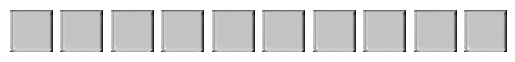

Epoch 11/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=1.1461]


Epoch 11 | Avg Loss: 1.1523


Epoch 12/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=1.1189]


Epoch 12 | Avg Loss: 1.1258


Epoch 13/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=1.1018]


Epoch 13 | Avg Loss: 1.1119


Epoch 14/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=1.0945]


Epoch 14 | Avg Loss: 1.1010


Epoch 15/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=1.0795]


Epoch 15 | Avg Loss: 1.0880


Epoch 16/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=1.1073]


Epoch 16 | Avg Loss: 1.0870


Epoch 17/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=1.0578]


Epoch 17 | Avg Loss: 1.0660


Epoch 18/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=1.0431]


Epoch 18 | Avg Loss: 1.0548


Epoch 19/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=1.0582]


Epoch 19 | Avg Loss: 1.0494


Epoch 20/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=1.0416]


Epoch 20 | Avg Loss: 1.0354


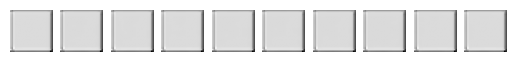

Epoch 21/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=1.0169]


Epoch 21 | Avg Loss: 1.0225


Epoch 22/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=1.0051]


Epoch 22 | Avg Loss: 1.0131


Epoch 23/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=1.0091]


Epoch 23 | Avg Loss: 1.0018


Epoch 24/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.9831]


Epoch 24 | Avg Loss: 0.9935


Epoch 25/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.9853]


Epoch 25 | Avg Loss: 0.9802


Epoch 26/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.9524]


Epoch 26 | Avg Loss: 0.9766


Epoch 27/200: 100%|██████████| 47/47 [00:07<00:00,  6.32it/s, Loss=0.9307]


Epoch 27 | Avg Loss: 0.9504


Epoch 28/200: 100%|██████████| 47/47 [00:07<00:00,  6.40it/s, Loss=0.9098]


Epoch 28 | Avg Loss: 0.9205


Epoch 29/200: 100%|██████████| 47/47 [00:07<00:00,  6.35it/s, Loss=0.8980]


Epoch 29 | Avg Loss: 0.9028


Epoch 30/200: 100%|██████████| 47/47 [00:07<00:00,  6.40it/s, Loss=0.8814]


Epoch 30 | Avg Loss: 0.8933


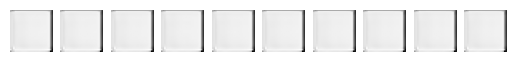

Epoch 31/200: 100%|██████████| 47/47 [00:07<00:00,  6.40it/s, Loss=0.8641]


Epoch 31 | Avg Loss: 0.9054


Epoch 32/200: 100%|██████████| 47/47 [00:07<00:00,  6.15it/s, Loss=0.8750]


Epoch 32 | Avg Loss: 0.8791


Epoch 33/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.8741]


Epoch 33 | Avg Loss: 0.8598


Epoch 34/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.8353]


Epoch 34 | Avg Loss: 0.8428


Epoch 35/200: 100%|██████████| 47/47 [00:07<00:00,  6.15it/s, Loss=0.8142]


Epoch 35 | Avg Loss: 0.8305


Epoch 36/200: 100%|██████████| 47/47 [00:07<00:00,  6.20it/s, Loss=0.8139]


Epoch 36 | Avg Loss: 0.8156


Epoch 37/200: 100%|██████████| 47/47 [00:07<00:00,  6.23it/s, Loss=0.7973]


Epoch 37 | Avg Loss: 0.8004


Epoch 38/200: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, Loss=0.7686]


Epoch 38 | Avg Loss: 0.7846


Epoch 39/200: 100%|██████████| 47/47 [00:07<00:00,  6.13it/s, Loss=0.7717]


Epoch 39 | Avg Loss: 0.7690


Epoch 40/200: 100%|██████████| 47/47 [00:07<00:00,  6.21it/s, Loss=0.7552]


Epoch 40 | Avg Loss: 0.7487


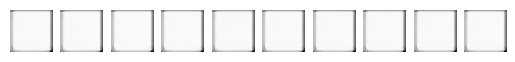

Epoch 41/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.7106]


Epoch 41 | Avg Loss: 0.7294


Epoch 42/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.7239]


Epoch 42 | Avg Loss: 0.7035


Epoch 43/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.6596]


Epoch 43 | Avg Loss: 0.6735


Epoch 44/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.6270]


Epoch 44 | Avg Loss: 0.6479


Epoch 45/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.6149]


Epoch 45 | Avg Loss: 0.6248


Epoch 46/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.5867]


Epoch 46 | Avg Loss: 0.6032


Epoch 47/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.5749]


Epoch 47 | Avg Loss: 0.5907


Epoch 48/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.5570]


Epoch 48 | Avg Loss: 0.5653


Epoch 49/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.5393]


Epoch 49 | Avg Loss: 0.5571


Epoch 50/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.5256]


Epoch 50 | Avg Loss: 0.5422


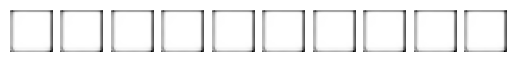

Epoch 51/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.5216]


Epoch 51 | Avg Loss: 0.5330


Epoch 52/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.5126]


Epoch 52 | Avg Loss: 0.5181


Epoch 53/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.5009]


Epoch 53 | Avg Loss: 0.5092


Epoch 54/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.4899]


Epoch 54 | Avg Loss: 0.5002


Epoch 55/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.5036]


Epoch 55 | Avg Loss: 0.4930


Epoch 56/200: 100%|██████████| 47/47 [00:08<00:00,  5.81it/s, Loss=0.5108]


Epoch 56 | Avg Loss: 0.4876


Epoch 57/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.4791]


Epoch 57 | Avg Loss: 0.4815


Epoch 58/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.4729]


Epoch 58 | Avg Loss: 0.4671


Epoch 59/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.4951]


Epoch 59 | Avg Loss: 0.4640


Epoch 60/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.4400]


Epoch 60 | Avg Loss: 0.4549


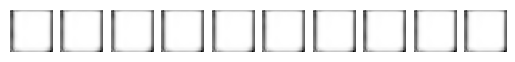

Epoch 61/200: 100%|██████████| 47/47 [00:08<00:00,  5.80it/s, Loss=0.4404]


Epoch 61 | Avg Loss: 0.4340


Epoch 62/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.4366]


Epoch 62 | Avg Loss: 0.4283


Epoch 63/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.4028]


Epoch 63 | Avg Loss: 0.4195


Epoch 64/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.3923]


Epoch 64 | Avg Loss: 0.4003


Epoch 65/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.3966]


Epoch 65 | Avg Loss: 0.3906


Epoch 66/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.3807]


Epoch 66 | Avg Loss: 0.3841


Epoch 67/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.3683]


Epoch 67 | Avg Loss: 0.3782


Epoch 68/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.3652]


Epoch 68 | Avg Loss: 0.3706


Epoch 69/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.3650]


Epoch 69 | Avg Loss: 0.3646


Epoch 70/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.3504]


Epoch 70 | Avg Loss: 0.3556


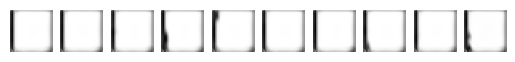

Epoch 71/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.3493]


Epoch 71 | Avg Loss: 0.3504


Epoch 72/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.3412]


Epoch 72 | Avg Loss: 0.3432


Epoch 73/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.3306]


Epoch 73 | Avg Loss: 0.3375


Epoch 74/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.3338]


Epoch 74 | Avg Loss: 0.3343


Epoch 75/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.3116]


Epoch 75 | Avg Loss: 0.3200


Epoch 76/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.3211]


Epoch 76 | Avg Loss: 0.3102


Epoch 77/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.3043]


Epoch 77 | Avg Loss: 0.3127


Epoch 78/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.2895]


Epoch 78 | Avg Loss: 0.3016


Epoch 79/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.2838]


Epoch 79 | Avg Loss: 0.2905


Epoch 80/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.2844]


Epoch 80 | Avg Loss: 0.2825


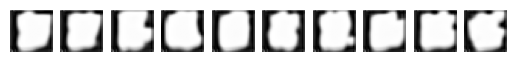

Epoch 81/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.2735]


Epoch 81 | Avg Loss: 0.2767


Epoch 82/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.2686]


Epoch 82 | Avg Loss: 0.2714


Epoch 83/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.2629]


Epoch 83 | Avg Loss: 0.2666


Epoch 84/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.2568]


Epoch 84 | Avg Loss: 0.2649


Epoch 85/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.2553]


Epoch 85 | Avg Loss: 0.2588


Epoch 86/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.2530]


Epoch 86 | Avg Loss: 0.2535


Epoch 87/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.2513]


Epoch 87 | Avg Loss: 0.2513


Epoch 88/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.2438]


Epoch 88 | Avg Loss: 0.2478


Epoch 89/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.2347]


Epoch 89 | Avg Loss: 0.2436


Epoch 90/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.2375]


Epoch 90 | Avg Loss: 0.2395


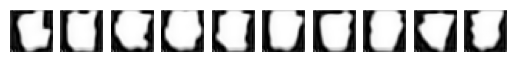

Epoch 91/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.2372]


Epoch 91 | Avg Loss: 0.2360


Epoch 92/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.2316]


Epoch 92 | Avg Loss: 0.2338


Epoch 93/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.2295]


Epoch 93 | Avg Loss: 0.2299


Epoch 94/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.2336]


Epoch 94 | Avg Loss: 0.2290


Epoch 95/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.2298]


Epoch 95 | Avg Loss: 0.2269


Epoch 96/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.2198]


Epoch 96 | Avg Loss: 0.2231


Epoch 97/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.2213]


Epoch 97 | Avg Loss: 0.2227


Epoch 98/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.2214]


Epoch 98 | Avg Loss: 0.2210


Epoch 99/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.2176]


Epoch 99 | Avg Loss: 0.2199


Epoch 100/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.2112]


Epoch 100 | Avg Loss: 0.2158


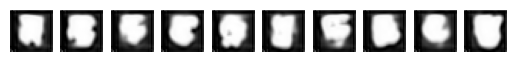

Epoch 101/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.2312]


Epoch 101 | Avg Loss: 0.2312


Epoch 102/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2132]


Epoch 102 | Avg Loss: 0.2252


Epoch 103/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.2121]


Epoch 103 | Avg Loss: 0.2127


Epoch 104/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.2092]


Epoch 104 | Avg Loss: 0.2084


Epoch 105/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.2060]


Epoch 105 | Avg Loss: 0.2068


Epoch 106/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.2015]


Epoch 106 | Avg Loss: 0.2053


Epoch 107/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.2022]


Epoch 107 | Avg Loss: 0.2049


Epoch 108/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.2028]


Epoch 108 | Avg Loss: 0.2035


Epoch 109/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.1992]


Epoch 109 | Avg Loss: 0.2020


Epoch 110/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2088]


Epoch 110 | Avg Loss: 0.2031


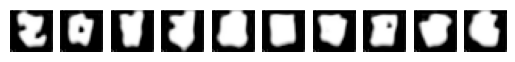

Epoch 111/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.2169]


Epoch 111 | Avg Loss: 0.2237


Epoch 112/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2021]


Epoch 112 | Avg Loss: 0.2127


Epoch 113/200: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, Loss=0.2070]


Epoch 113 | Avg Loss: 0.2068


Epoch 114/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.2074]


Epoch 114 | Avg Loss: 0.2069


Epoch 115/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.2050]


Epoch 115 | Avg Loss: 0.2059


Epoch 116/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.2124]


Epoch 116 | Avg Loss: 0.2049


Epoch 117/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.2031]


Epoch 117 | Avg Loss: 0.2033


Epoch 118/200: 100%|██████████| 47/47 [00:08<00:00,  5.81it/s, Loss=0.2152]


Epoch 118 | Avg Loss: 0.2072


Epoch 119/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.2171]


Epoch 119 | Avg Loss: 0.2137


Epoch 120/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.2113]


Epoch 120 | Avg Loss: 0.2076


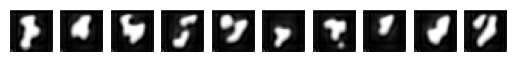

Epoch 121/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.1992]


Epoch 121 | Avg Loss: 0.2031


Epoch 122/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.1966]


Epoch 122 | Avg Loss: 0.2021


Epoch 123/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.2053]


Epoch 123 | Avg Loss: 0.2010


Epoch 124/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.1987]


Epoch 124 | Avg Loss: 0.2011


Epoch 125/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.2021]


Epoch 125 | Avg Loss: 0.2007


Epoch 126/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.2088]


Epoch 126 | Avg Loss: 0.2013


Epoch 127/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.2060]


Epoch 127 | Avg Loss: 0.2014


Epoch 128/200: 100%|██████████| 47/47 [00:08<00:00,  5.79it/s, Loss=0.1952]


Epoch 128 | Avg Loss: 0.2002


Epoch 129/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.1989]


Epoch 129 | Avg Loss: 0.2006


Epoch 130/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.2040]


Epoch 130 | Avg Loss: 0.2002


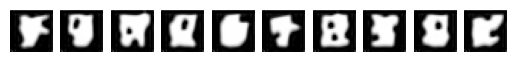

Epoch 131/200: 100%|██████████| 47/47 [00:08<00:00,  5.75it/s, Loss=0.1954]


Epoch 131 | Avg Loss: 0.1997


Epoch 132/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.2031]


Epoch 132 | Avg Loss: 0.1995


Epoch 133/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.2001]


Epoch 133 | Avg Loss: 0.1997


Epoch 134/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.2001]


Epoch 134 | Avg Loss: 0.2006


Epoch 135/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2040]


Epoch 135 | Avg Loss: 0.2024


Epoch 136/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.1939]


Epoch 136 | Avg Loss: 0.2015


Epoch 137/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.2050]


Epoch 137 | Avg Loss: 0.1998


Epoch 138/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1909]


Epoch 138 | Avg Loss: 0.2014


Epoch 139/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.2082]


Epoch 139 | Avg Loss: 0.2126


Epoch 140/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.2079]


Epoch 140 | Avg Loss: 0.2051


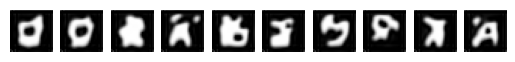

Epoch 141/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.2011]


Epoch 141 | Avg Loss: 0.2033


Epoch 142/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.1904]


Epoch 142 | Avg Loss: 0.2038


Epoch 143/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.2103]


Epoch 143 | Avg Loss: 0.2043


Epoch 144/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1965]


Epoch 144 | Avg Loss: 0.1982


Epoch 145/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.1869]


Epoch 145 | Avg Loss: 0.1923


Epoch 146/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.1855]


Epoch 146 | Avg Loss: 0.1915


Epoch 147/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.1876]


Epoch 147 | Avg Loss: 0.1906


Epoch 148/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.1888]


Epoch 148 | Avg Loss: 0.1906


Epoch 149/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.1894]


Epoch 149 | Avg Loss: 0.1903


Epoch 150/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.1854]


Epoch 150 | Avg Loss: 0.1890


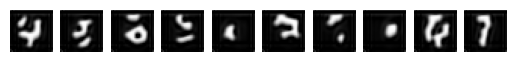

Epoch 151/200: 100%|██████████| 47/47 [00:08<00:00,  5.75it/s, Loss=0.1827]


Epoch 151 | Avg Loss: 0.1886


Epoch 152/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.1892]


Epoch 152 | Avg Loss: 0.1892


Epoch 153/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.1840]


Epoch 153 | Avg Loss: 0.1879


Epoch 154/200: 100%|██████████| 47/47 [00:08<00:00,  5.81it/s, Loss=0.1924]


Epoch 154 | Avg Loss: 0.1907


Epoch 155/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.1845]


Epoch 155 | Avg Loss: 0.1892


Epoch 156/200: 100%|██████████| 47/47 [00:08<00:00,  5.74it/s, Loss=0.1873]


Epoch 156 | Avg Loss: 0.1883


Epoch 157/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.1840]


Epoch 157 | Avg Loss: 0.1876


Epoch 158/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.1841]


Epoch 158 | Avg Loss: 0.1945


Epoch 159/200: 100%|██████████| 47/47 [00:08<00:00,  5.79it/s, Loss=0.1828]


Epoch 159 | Avg Loss: 0.1892


Epoch 160/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.1858]


Epoch 160 | Avg Loss: 0.1877


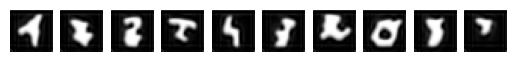

Epoch 161/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.1868]


Epoch 161 | Avg Loss: 0.1865


Epoch 162/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.1889]


Epoch 162 | Avg Loss: 0.1865


Epoch 163/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.1848]


Epoch 163 | Avg Loss: 0.1858


Epoch 164/200: 100%|██████████| 47/47 [00:08<00:00,  5.77it/s, Loss=0.1851]


Epoch 164 | Avg Loss: 0.1854


Epoch 165/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.1887]


Epoch 165 | Avg Loss: 0.1863


Epoch 166/200: 100%|██████████| 47/47 [00:08<00:00,  5.77it/s, Loss=0.1898]


Epoch 166 | Avg Loss: 0.1923


Epoch 167/200: 100%|██████████| 47/47 [00:08<00:00,  5.78it/s, Loss=0.1986]


Epoch 167 | Avg Loss: 0.1967


Epoch 168/200: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, Loss=0.1832]


Epoch 168 | Avg Loss: 0.1930


Epoch 169/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.1820]


Epoch 169 | Avg Loss: 0.1883


Epoch 170/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1906]


Epoch 170 | Avg Loss: 0.1884


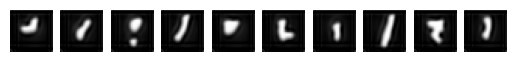

Epoch 171/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.1877]


Epoch 171 | Avg Loss: 0.1883


Epoch 172/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.1892]


Epoch 172 | Avg Loss: 0.1876


Epoch 173/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.1878]


Epoch 173 | Avg Loss: 0.1889


Epoch 174/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.1851]


Epoch 174 | Avg Loss: 0.1890


Epoch 175/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.1887]


Epoch 175 | Avg Loss: 0.1868


Epoch 176/200: 100%|██████████| 47/47 [00:08<00:00,  5.77it/s, Loss=0.1798]


Epoch 176 | Avg Loss: 0.1842


Epoch 177/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.1826]


Epoch 177 | Avg Loss: 0.1837


Epoch 178/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.1845]


Epoch 178 | Avg Loss: 0.1832


Epoch 179/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=0.1873]


Epoch 179 | Avg Loss: 0.1828


Epoch 180/200: 100%|██████████| 47/47 [00:07<00:00,  6.26it/s, Loss=0.1806]


Epoch 180 | Avg Loss: 0.1831


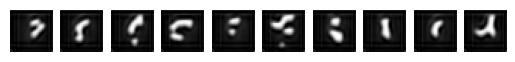

Epoch 181/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.1810]


Epoch 181 | Avg Loss: 0.1823


Epoch 182/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.1808]


Epoch 182 | Avg Loss: 0.1820


Epoch 183/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.1843]


Epoch 183 | Avg Loss: 0.1825


Epoch 184/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.1908]


Epoch 184 | Avg Loss: 0.1897


Epoch 185/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.1861]


Epoch 185 | Avg Loss: 0.1861


Epoch 186/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.1787]


Epoch 186 | Avg Loss: 0.1846


Epoch 187/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.1847]


Epoch 187 | Avg Loss: 0.1847


Epoch 188/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.1822]


Epoch 188 | Avg Loss: 0.1848


Epoch 189/200: 100%|██████████| 47/47 [00:08<00:00,  5.76it/s, Loss=0.1812]


Epoch 189 | Avg Loss: 0.1827


Epoch 190/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.1809]


Epoch 190 | Avg Loss: 0.1812


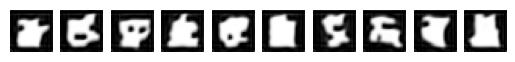

Epoch 191/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.1775]


Epoch 191 | Avg Loss: 0.1814


Epoch 192/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.1823]


Epoch 192 | Avg Loss: 0.1803


Epoch 193/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.1844]


Epoch 193 | Avg Loss: 0.1796


Epoch 194/200: 100%|██████████| 47/47 [00:07<00:00,  6.28it/s, Loss=0.1767]


Epoch 194 | Avg Loss: 0.1801


Epoch 195/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1793]


Epoch 195 | Avg Loss: 0.1797


Epoch 196/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.1782]


Epoch 196 | Avg Loss: 0.1800


Epoch 197/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1742]


Epoch 197 | Avg Loss: 0.1801


Epoch 198/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.1834]


Epoch 198 | Avg Loss: 0.1845


Epoch 199/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.1778]


Epoch 199 | Avg Loss: 0.1820


Epoch 200/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.1800]


Epoch 200 | Avg Loss: 0.1793


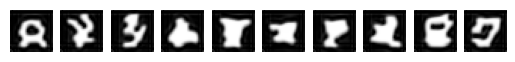

Training completed!


In [8]:
train_dataset = torchvision.datasets.MNIST(
    root="~/ainotebook/data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
best_loss = float("inf")
sample = True
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config["max_grad_norm"]
        )  # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    if sample and (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(1, 28, 28))
            for i, img in enumerate(sampled_images):
                plt.subplot(1, 10, i + 1)
                plt.imshow(img.squeeze().cpu(), cmap="gray")
                plt.axis("off")
            plt.show()

    if (epoch + 1) % config["save_interval"] == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": avg_loss,
            },
            f"checkpoints/checkpoint_{epoch+1:03d}.pth",
        )

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")